In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Entropy and the Boltzmann Distribution

Recall _entropy_, the measure of uncertainty about a system given its macroscopic properties (e.g., temperature, pressure, volume).  It measures how probability is spread over the possible _microstates_ of the system.

$$
S = -k\sum_\omega p_\omega \log p_\omega,
$$

where $\omega$ enumerates all possible microstates, and $p_\omega$ is the probability of the system occupying each state.  This is the _statistical mechanics_ definition of entropy.  The _thermodynamic_ definition of entropy $dS = \frac{\delta Q}{T}$ relating the change in entropy in a closed system to incremental and reversable transfer of heat $\delta Q$ into that system of temperature $T$.  Demanding these definitions be equal (and making use of the _fundamental thermodynamic relation_ $dU = T dS - p dV$) leads to the _Boltzmann distribution_ as the solution for describing the probability of a system occupying a particular microstate $\omega$ is

$$
p_\omega = \frac{e^{-E_\omega/kT}}{Z},
$$

where $Z$ the normalization constant resulting from summing the numerator over all possible microstates of the system $\Omega$

$$
Z = \sum_{\omega'\in \Omega}e^{-E_{\omega'}/kT}.
$$

## The Ising Model

We'll use the Boltzmann distribution above to simulate a ferromagnet using a simple, two-dimensional _Ising model_. This model constructs a ferromagnet as a 2-D lattice with $N$ sites, and the spin of each lattice site can be up or down, which we'll representent as $+1$ and $-1$, respectively.

A configuration of the microstate of this system is given by $\omega = \{\omega_1, \omega_2, \dots, \omega_N\}$, where $\omega_i=\pm 1$, meaning there are $|\Omega|=2^N$ possible microstates of the system.

Let's construct a small latice with random initial spins.

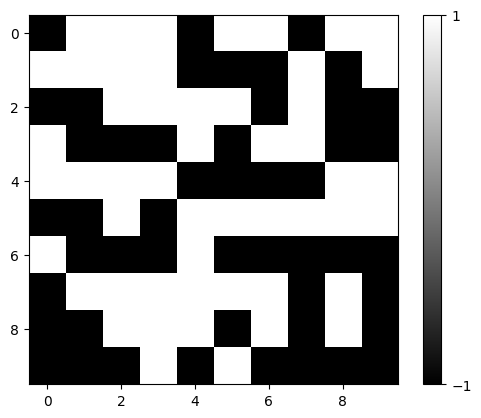

In [2]:
ngrid = 10
N = int(ngrid**2)

state = np.random.choice([-1, 1], size=(ngrid, ngrid))
plt.imshow(state, cmap='gray')
cbar = plt.colorbar()
cbar.set_ticks([-1, 1]);

We'll define the energy of a particular configuration to be

$$
E_\omega = -J\sum_{\left<i,j\right>}\omega_i\omega_j - H\sum_{i=1}^N\omega_i,
$$

where $\left<i,j\right>$ indicates adjacent (i.e., nearest neighbor) sites (vertically or horizontally), $J>0$ drives the strength of coupling between nearest-neighbors, and $H>0$ represents the strength of an external field.

In [3]:
def energy(state, J=1., H=0.):
    steps = [1, -1]
    axes = [0, 1]
    E = 0
    for step in steps:
        for axis in axes:
            E -= J * np.sum(state * np.roll(state, step, axis=axis))
    E -= H * np.sum(state)
    return E

In [4]:
energy(state)

0.0

Now that we can calculate the energy of any particular microstate $\omega$, we can calculate the (relative) probability of occupying that state using the Boltzmann distribution.

In [5]:
def lnBoltz(state, kT=1., J=1., H=0.):
    return -energy(state, J=J, H=H)/kT

I say relative here because we haven't gone through the effort of summing the numerator of the Boltzmann distribution over all possible microstates (i.e., we haven't normalized the distribution).  With this we can calculate the _relative_ probability of the system occupying two different microstates.

In [6]:
def draw_state(N):
    ngrid = int(np.sqrt(N))
    return np.random.choice([-1, 1], size=(ngrid, ngrid))

log(P1/P2) = -8.0
P1/P2 = 0.00033546262790251185


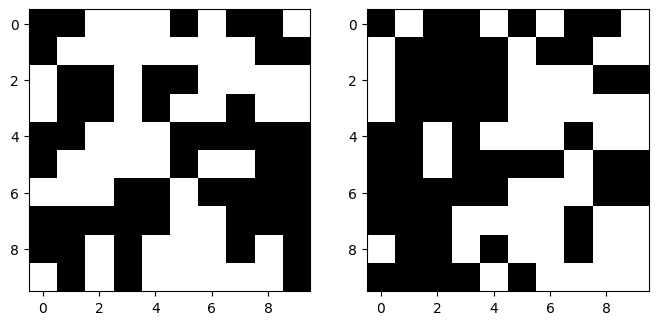

In [7]:
state1 = draw_state(N)
state2 = draw_state(N)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(state1, cmap='gray')
axs[1].imshow(state2, cmap='gray')
log_P_rel = lnBoltz(state1) - lnBoltz(state2)
print("log(P1/P2) = {}".format(log_P_rel))
print("P1/P2 = {}".format(np.exp(log_P_rel)))

## Phase Transition

We can use our model to explore phase transitions, particularly in the _magnetization_. The _magnetization_ of our model for a particular microstate $\omega$ is

$$
M_\omega = \sum_{i=1}^N \omega_i.
$$

To determine the macroscopic magnetization at temperature $T$ we need to calculate the expectation value of this magnetization over possible microstates $\left<M\right>_T$.

$$
\left<M\right>_T = \sum_{\omega \in \Omega} M_\omega p(\omega) = \sum_{\omega \in \Omega} M_\omega \mathrm{Boltz(\omega)}.
$$

Importance sampling to the rescue!  Recall that using some sampling distribution $g(\omega)$ we can estimate such an expectation value using $S$ draws $\omega^1, \dots, \omega^S$ from $g(\omega)$ as

$$
E(h(\omega)) = \frac{\sum_{s=1}^S h(\omega^s) w(\omega^s)}{\sum_{s=1}^S w(\omega^s)}
$$

where

$$
w(\omega^s) = \frac{\mathrm{Boltz}(\omega^s)}{g(\omega^s)}
$$

are the _importance weights_.

Let's use our `draw_state()` function as our sampling distribution.  Since it's uniform over each lattice point's possible spin value $\omega_i$ we don't need to worry about explicitly calculating it for our importance weights (there's just a normalization constant that cancels).  To avoid overflow/underflow we're going to stick to working in the (natural) log as much as possible.

In [8]:
def magnetization(state):
    return np.sum(state)

In [9]:
S = 1000
M_omegas = []
lnws = []
for _ in range(S):
    state = draw_state(N)
    M_omegas.append(magnetization(state))
    lnws.append(lnBoltz(state))

M_omegas = np.array(M_omegas)
lnws = np.array(lnws)

To avoid having to explicitly exponentiate each log term, sum over them, then take the log again (a process very prone to over/underflow, we can make use of some mathematical tricks with `logsumexp()`.

In [10]:
from scipy.special import logsumexp

We can use this fuction to calculate, for example, the log of the sum of the weights in the following way.

In [11]:
log_sum_ws = logsumexp(lnws)
log_sum_ws

81.38679779418958

For the numerator of our importance sampling we need to multiply each weight by the magnetization, which we can do with the `b=` keyword argument.  This should be everything we need.

In [12]:
E_M = np.exp(logsumexp(lnws, b=M_omegas, return_sign=True)[0] - logsumexp(lnws))
E_M

1.5059524915742608

...but weight.  We should look at them. 

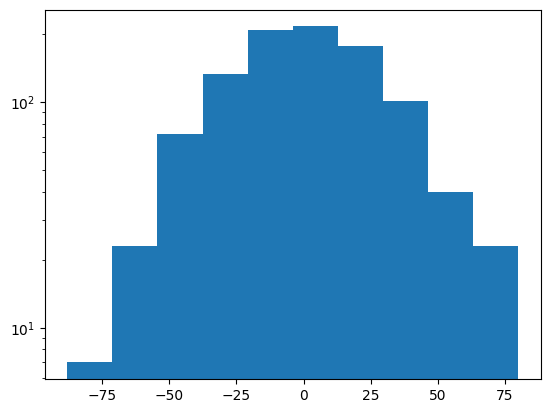

In [13]:
plt.hist(lnws, log=True);

From Chap. 10 of Gelman, we know that we should look at the distribution of weights to get a sense of the accuracy of our estimate.  If there are relatively few extreme weights, then their contributions will dominate our estimate above.  To be more quantitative, we can estimate the effective sample size (ESS).  If this is $>>1$ we're in good shape, and if it's $\sim 1$, not so good....

In [14]:
def ess(lnws):
    normalized_lnws = lnws - logsumexp(lnws)
    log_ess = -logsumexp(2*normalized_lnws)
    return np.exp(log_ess)

In [15]:
ess(lnws)

4.004028816905705

😬

and this is for a small latice!  We must do better!

# Markov Chain

Given a finite state space $\mathbb{S}=\{1, 2, \dots, M\}$, a _Markov chain_ is a stochasic process consisting of a sequence of random variables $X_i \in \mathbb{S}$ for $i=1, 2, \dots$ where the probability of being in a particular state at step $k+1$ _only_ depends on what the state was at step $k$:

$$
P(X_{k+1}=x_{k+1}|X_1=x_1, \dots, X_k=x_k) = P(X_{k+1}=x_{k+1}|X_k=x_k).
$$

In the context of our Ising model, think of $x_k$ being a particular microstate of our lattice model, and a Markov chain being a stochastic process that randomly changes the spins in our lattice to produce different microstates.


# Metropolis Algorithm

To build a Markov chain we need to specify _how_ the probability of being in a particular microstate at step $k+1$ depends on the microstate at the previous step $k$. In particular, we would like to produce a Markov chain that produces random samples from the Boltzmann distribution.  We'll do this in two parts:
1. Define a method for proposing a modification to the state at step $k$.
1. Define a criteria for _accepting_ that proposed state.

Let's switch from $x$ to $\omega$ to describe our state space, and say that for step (1) we have some sampling distribution $G$ that provides us with a proposed new state $\omega'$ based on our current state $\omega$.  We'll get into the _how_ of this in a bit, but we'll use $G(\omega\rightarrow\omega')$ to indicate the probability of proposing state $\omega'$ from a state $\omega$.

Since our goal is to produce a Markov chain that samples the Boltzmann distribution, we should probably expect step (2) to involve it.  Let's consider the following _probabalistic_ acceptance criteria:
$$
P_\mathrm{accept} = \min{\left(\frac{\mathrm{Boltz}(\omega')}{\mathrm{Boltz}(\omega)},1\right)},
$$
in other words, if the probability of the new state is higher we accept the jump, and if it's lower we accept it with a probability equal to the ratio of the Boltzmann probabilities.

Putting this all together, the probabilitly of proposing _and_ accepting a stochastic move $\omega\rightarrow\omega'$ is:

$$
P(\omega\rightarrow\omega') = G(\omega\rightarrow\omega') \min{\left(\frac{\mathrm{Boltz}(\omega')}{\mathrm{Boltz}(\omega)},1\right)}
$$

and the probability of the opposite transition is

$$
P(\omega'\rightarrow\omega) = G(\omega'\rightarrow\omega) \min{\left(\frac{\mathrm{Boltz}(\omega)}{\mathrm{Boltz}(\omega')},1\right)}.
$$

Now let's consider the ratio of the transition probabilities:

$$
\frac{P(\omega\rightarrow\omega')}{P(\omega'\rightarrow\omega)} = \frac{G(\omega\rightarrow\omega')}{G(\omega'\rightarrow\omega)}\frac{\mathrm{Boltz}(\omega')}{\mathrm{Boltz}(\omega)}.
$$

If, for simplicity, we choose a symmetric sampling distribution such that $G(\omega\rightarrow\omega')= G(\omega'\rightarrow\omega)$, then the relative probability of transition is equal to the relative value of the Boltzmann distribution!

$$
\frac{P(\omega\rightarrow\omega')}{P(\omega'\rightarrow\omega)} = \frac{\mathrm{Boltz}(\omega')}{\mathrm{Boltz}(\omega)} = e^{-\Delta E/kT}
$$

Moreover, it only involves the _ratio_ of Boltzmann probabilities, so we don't have to worry about calculating the partition function!

Let's try this out on our lattice model.  The last thing we need is a sampling (or proposal) distribution.  For the Metropolis algorithm we outlined above, we need to make sure that it's _symmetric_, and as we saw in our draws above, changing too many lattice values at once produces _very_ different energies.  So let's just change one lattice value (chosen randomly) at a time.

In [16]:
def proposal(current_state, n=1):
    N = current_state.size
    flip = np.ones(N)
    flip[np.random.choice(N, size=n)] = -1
    return current_state * flip.reshape(current_state.shape)

In [17]:
def bad_proposal(current_state):
    return np.random.choice([-1, 1], size=current_state.shape)

Now we set up the problem and an initial state for our Markov chain.

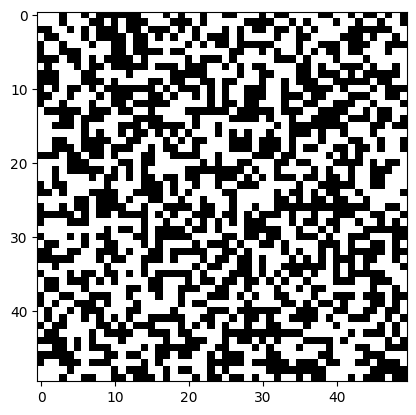

In [18]:
kT = 10.
J = 1.
H = 0.

energy_fun = lambda state: energy(state, J=J, H=H)
lnBoltz_fun = lambda state: lnBoltz(state, kT=kT, J=J, H=H)

ngrid = 50
N = int(ngrid**2)
initial_state = draw_state(N)
plt.imshow(initial_state, cmap='gray');

In [19]:
current_state = initial_state
current_lnBoltz = lnBoltz_fun(current_state)

Nsteps = 10000
energies = []
magnetizations = []
for _ in range(Nsteps):
    # Store some quantities
    energies.append(energy_fun(current_state))
    magnetizations.append(magnetization(current_state))

    # Generate proposal
    proposed_state = proposal(current_state, n=1)
    proposed_lnBoltz = lnBoltz_fun(proposed_state)

    # Compute acceptance probability
    ln_prob = proposed_lnBoltz - current_lnBoltz

    # Apply accetance criteria
    if np.log(np.random.rand()) < ln_prob:
        current_state = proposed_state
        current_lnBoltz = proposed_lnBoltz

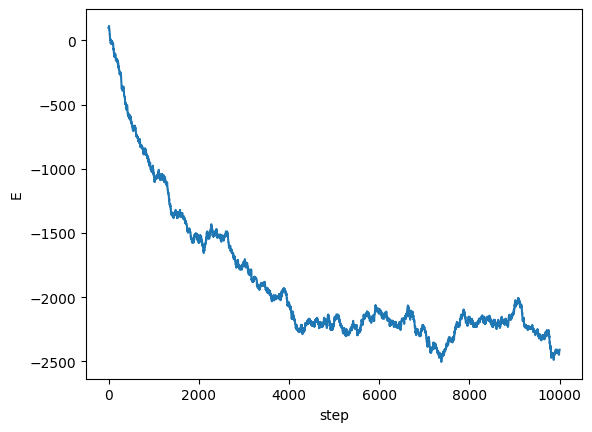

In [20]:
plt.plot(energies[-10000:])
plt.xlabel('step')
plt.ylabel("E");

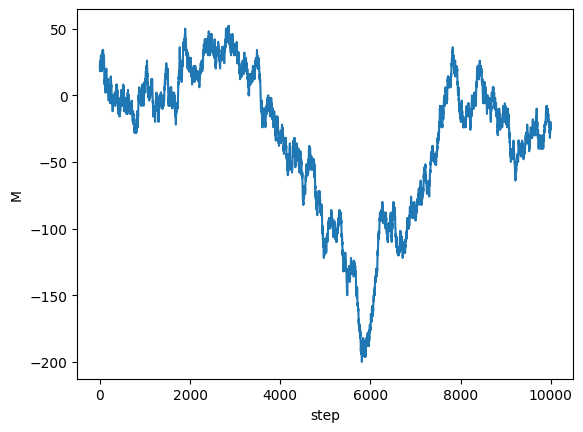

In [21]:
plt.plot(magnetizations)
plt.xlabel('step')
plt.ylabel("M");

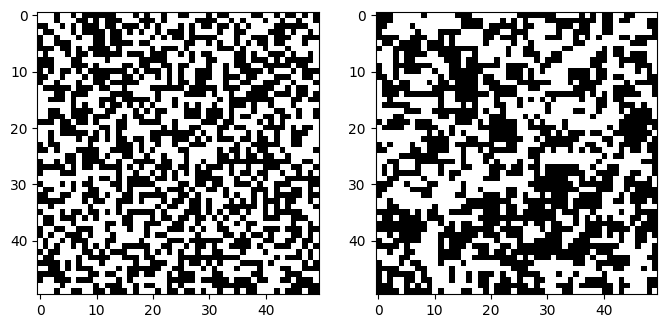

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(initial_state, cmap='gray')
axs[1].imshow(current_state, cmap='gray');

We can see our Markov chain _quickly_ running to lower energies (i.e., higher probabilities), but it eventually stabilizes. The final state of the chain, which should be a reasonably fair draw from the Boltzmann distribution, looks a bit more clumpy than the initial (random) state.

Play with the temperature and coefficients to see if you can find phase transitions.